In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from textwrap import TextWrapper

pd.set_option('display.max_columns', None)

In [2]:
def to_date(date: str):
    try:
        return (datetime.strptime('1900-01-01', '%Y-%m-%d')
                + timedelta(days=int(date) - 1)).strftime('%d/%m/%Y')
    except ValueError:
        return str(date)

In [3]:
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 300

In [4]:
text_wrapper = TextWrapper(width=15)

In [5]:
PATH = "../data/1_datos"
RENDER_PATH = "renders"

In [6]:
bdp_general = pd.read_csv(f"{PATH}/BDP_GENERAL/BDP_GENERAL.csv")

bdp_general['FECHA'] = pd.to_datetime(
    bdp_general['FECHA'].apply(
        to_date
    ).replace(
        {
            '02/08/210': '02/08/2010',
            '12705/1997': '12/05/1997',
            '15-07-2010': '15/07/2010',
            '16-07-2010': '16/07/2010',
            '24/071991': '24/07/1991',
            '2708/1991': '27/08/1991',
            '28/006/2010': '28/06/2010',
            '29-08-1980': '29/08/1980',
            '31/.8/1991': '31/08/1991',
        }
    ),
    errors='coerce'
)

bdp_general.head()

,MEMORIA,EDAFOLOGO,COD_PERFIL,TIPO_PERFIL,CATEGORIA_PERFIL,ESTUDIO_ORIGEN,FECHA,SIMBOLO_UCS,TIPO_UCS,DEPARTAMENTO,COD_DEPTO,MUNICIPIO,SITIO,CLIMA_AMBIENTAL,PAISAJE,TIPO_RELIEVE,FORMA_TERRENO,MATERIAL_PARENTAL_LITOLOGIA,GRADO_ALTERACIÓN_MP,CLASE_PENDIENTE,DISECCION,MICRORELIEVE,PORC_PENDIENTE,LONGITUD_PENDIENTE,FORMA_PENDIENTE,FORMACION_ECOLOGICA,T_PROM_ANUAL,PRECIPITACION_PROM_ANUAL,DISTRIBUCION_LLUVIAS,REGIMEN_TEMPERATURA,REGIMEN_HUMEDAD,CLASE_DEGRADACION,TIPO_DEGRADACION,CLASE_EROSION,TIPO_EROSION,GRADO_EROSION,EVIDENCIAS_EROSION,CLASE_MOVIMIENTO_MASA,TIPO_MOVIMIENTO_MASA,FRECUENCIA_MOVIMIENTO_MASA,DRENAJE_INTERNO,DRENAJE_EXTERNO,DRENAJE_NATURAL,NIVEL_FREATICO,PROF_NIVEL_FREATICOcm,PROFUNDIDAD_EFECTIVA,LIMITANTES_PROFUNDIDAD_EFECTIVA,AGENTE_CEMENTANTE,CEMENTACION_GRADO,PLINTITA_VOLUMEN,PLINTITA_FASE,TIPO_PEDREGOSIDAD,PORC_PEDREGOSIDAD_SUPERFICIAL_CUBIERTA,CLASE_PEDREGOSIDAD,PORC_AFLORAMIENTO_SUPERFICIE_CUBIERTA,CLASE_AFLORAMIENTO,FASE_INUNDACION_ENCHARCAMIENTO,FRECUENCIA_INUNDACION,DURACION_INUNDACION,FRECUENCIA_ENCHARCAMIENTO,DURACION_ENCHARCAMIENTO,OBSERVACIONES_HORIZONTES,USO_ACTUAL,VEGETACION_NATURAL,NOMBRES_CULTIVOS_PASTOS,LIMITANTE_USO,CLASE_CLASIF_AGROLOGICA,SUBCLASE_CLASIF_AGROLOGICA,GRIETAS_ANCHO_mm,GRIETAS_PROFUNDIDAD_cm,CARACTERISTICAS_DIAGNOSTICAS,EPIPEDON,ENDOPEDON_1,ENDOPEDON_2,CLASIFICACION_TAXONOMICA,FAMILIA_TEXTURAL,GRADOS_N,MINUTOS_N,SEGUNDOS_N,GRADOS_W,MINUTOS_W,SEGUNDOS_W,LATITUD,LONGITUD,ALTITUD,OBSERVACIONES_GENERALES,FASE_desp_fam_text
0,AMAZONAS,"Edna Garzón, Marco Velandia y Celso Ibarra",AMA-PA-001,Modal,Existente,G_AMAZONAS,1994-02-13,RC,Complejo,Amazonas,91,Leticia,Hacienda los Andes (km 7 vía Tarapacá),"Cálido, húmedo",Planicie,Plano de inundación,Plano de terraza,"Aluviones subrecientes heterométricos , proven...",NaN,Ligeramente plana,Ligeramente disectado,NaN,1 - 3,Larga 100 - 300 metros,Recta,Bosque húmedo tropical,>24°C,2000 - 4000 mm,"Excesivas durante los dos semestres, permite c...",Isohipertérmico,Perúdico,No hay,NaN,NaN,NaN,NaN,NaN,No hay,NaN,NaN,Moderado,Moderado,Bien drenado,No aparece,NaN,Moderadamente superficial (50cm - 75cm),Material compactado,NaN,NaN,NaN,NaN,No hay,< 0.1,No hay,No hay,NaN,No hay,NaN,NaN,NaN,NaN,"El horizonte Bt3 es de 115 – 150x cm, presenta...",Ganadería,Palmas,Pastos enrastrojados,Lluvias excesivas durante un semestre (Según...,NaN,NaN,NaN,NaN,Regímenes de humedad,Ócrico,Argílico,NaN,Typic Paleudults,Fina,4.0,9.0,27,69.0,56.0,54,-69.948333,4.157500,84,Imagen radar: 568,a
1,AMAZONAS,"Edna Garzón, Marco Velandia y Celso Ibarra",AMA-PA-002,Inclusión,Existente,G_AMAZONAS,1994-02-13,RC,Complejo,Amazonas,91,Leticia,"Km 17, Leticia-Tarapacá","Cálido, húmedo",Planicie,Plano de inundación,Banco,"Aluviones subrecientes heterométricos , proven...",NaN,Ligeramente plana,Ligeramente disectado,NaN,1 - 3,Larga 100 - 300 metros,Recta,Bosque húmedo tropical,>24°C,2000 - 4000 mm,"Excesivas durante los dos semestres, permite c...",Isohipertérmico,Perúdico,No hay,NaN,NaN,NaN,NaN,NaN,No hay,NaN,NaN,Rápido,Moderado,Bien drenado,No aparece,NaN,Profunda (100cm - 150cm),Sin limitaciones,NaN,NaN,NaN,NaN,No hay,< 0.1,No hay,No hay,NaN,No hay,NaN,NaN,NaN,NaN,No hay,Ganadería,Destruida,No hay,Lluvias excesivas durante los dos semestres ...,NaN,NaN,NaN,NaN,Ausencia de horizontes diagnósticos,Ócrico,No hay,NaN,Typic Udorthents,Franca-gruesa,4.0,5.0,32,60.0,59.0,26,-60.990556,4.092222,84,Imagen radar: 568,a
2,AMAZONAS,"Edna Garzón, Marco Velandia y Celso Ibarra",AMA-PA-003,Modal,Existente,G_AMAZONAS,1994-03-07,LA,Asociación,Amazonas,91,Puerto Nariño,"Tipizca, (400 m al sur del caserío)","Cálido, húmedo",Lomerío,Lomas,Cima,Arcillolitas del terciario marino,NaN,Fuertemente ondulada,Ligeramente disectado,NaN,12 - 25,Media 50 - 100 metros,Convexa,Bosque húmedo tropical,>24°C,2000 - 4000 mm,"Excesivas durante los dos semestres, permite c...",Isohipertérmico,Perúdico,No hay,NaN,NaN,NaN,NaN,NaN,No hay,NaN,NaN,Moderado,Rápido,Bien drenado,No aparece,NaN,Moderadamente profunda (75cm - 100cm),Material

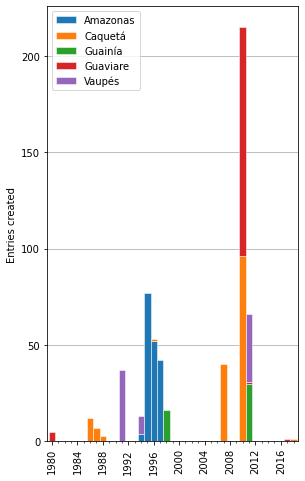

In [7]:
timeline = bdp_general.assign(year=bdp_general['FECHA'].dt.year).pivot_table(
    values='COD_PERFIL',
    index='year',
    columns='DEPARTAMENTO',
    aggfunc='count',
    fill_value=0
)

fig, ax = plt.subplots(figsize=(4.5, 8))

timeline = timeline.merge(
    pd.Series(
        index=np.arange(timeline.index.min(), timeline.index.max() + 1, dtype=int),
        dtype=int,
        name='empty'
    ),
    left_index=True,
    right_index=True,
    how='right'
).drop(
    columns='empty'
).fillna(
    0
)

timeline.plot.bar(
    stacked=True,
    width=1,
    edgecolor='w',
    linewidth=0.5,
    zorder=2,
    ax=ax
)

ax.xaxis.set_major_locator(
    MaxNLocator(prune='both', nbins=12)
)

ax.xaxis.set_minor_locator(
    MaxNLocator(nbins=len(timeline) + 1)
)

ax.grid(
    axis='y',
    zorder=0
)

ax.set_ylabel('Entries created')

fig.savefig(f"{RENDER_PATH}/timeline.png")

In [8]:
resumed_fields = pd.concat(
    [
        bdp_general.nunique().to_frame(name='unique_values'),
        bdp_general.isna().sum().to_frame(name='nan_values'),
        bdp_general.dtypes.to_frame(name='field_type').astype(str)
    ],
    axis=1
).T

resumed_fields.head()

,MEMORIA,EDAFOLOGO,COD_PERFIL,TIPO_PERFIL,CATEGORIA_PERFIL,ESTUDIO_ORIGEN,FECHA,SIMBOLO_UCS,TIPO_UCS,DEPARTAMENTO,COD_DEPTO,MUNICIPIO,SITIO,CLIMA_AMBIENTAL,PAISAJE,TIPO_RELIEVE,FORMA_TERRENO,MATERIAL_PARENTAL_LITOLOGIA,GRADO_ALTERACIÓN_MP,CLASE_PENDIENTE,DISECCION,MICRORELIEVE,PORC_PENDIENTE,LONGITUD_PENDIENTE,FORMA_PENDIENTE,FORMACION_ECOLOGICA,T_PROM_ANUAL,PRECIPITACION_PROM_ANUAL,DISTRIBUCION_LLUVIAS,REGIMEN_TEMPERATURA,REGIMEN_HUMEDAD,CLASE_DEGRADACION,TIPO_DEGRADACION,CLASE_EROSION,TIPO_EROSION,GRADO_EROSION,EVIDENCIAS_EROSION,CLASE_MOVIMIENTO_MASA,TIPO_MOVIMIENTO_MASA,FRECUENCIA_MOVIMIENTO_MASA,DRENAJE_INTERNO,DRENAJE_EXTERNO,DRENAJE_NATURAL,NIVEL_FREATICO,PROF_NIVEL_FREATICOcm,PROFUNDIDAD_EFECTIVA,LIMITANTES_PROFUNDIDAD_EFECTIVA,AGENTE_CEMENTANTE,CEMENTACION_GRADO,PLINTITA_VOLUMEN,PLINTITA_FASE,TIPO_PEDREGOSIDAD,PORC_PEDREGOSIDAD_SUPERFICIAL_CUBIERTA,CLASE_PEDREGOSIDAD,PORC_AFLORAMIENTO_SUPERFICIE_CUBIERTA,CLASE_AFLORAMIENTO,FASE_INUNDACION_ENCHARCAMIENTO,FRECUENCIA_INUNDACION,DURACION_INUNDACION,FRECUENCIA_ENCHARCAMIENTO,DURACION_ENCHARCAMIENTO,OBSERVACIONES_HORIZONTES,USO_ACTUAL,VEGETACION_NATURAL,NOMBRES_CULTIVOS_PASTOS,LIMITANTE_USO,CLASE_CLASIF_AGROLOGICA,SUBCLASE_CLASIF_AGROLOGICA,GRIETAS_ANCHO_mm,GRIETAS_PROFUNDIDAD_cm,CARACTERISTICAS_DIAGNOSTICAS,EPIPEDON,ENDOPEDON_1,ENDOPEDON_2,CLASIFICACION_TAXONOMICA,FAMILIA_TEXTURAL,GRADOS_N,MINUTOS_N,SEGUNDOS_N,GRADOS_W,MINUTOS_W,SEGUNDOS_W,LATITUD,LONGITUD,ALTITUD,OBSERVACIONES_GENERALES,FASE_desp_fam_text
unique_values,5,60,601,3,4,8,289,144,5,5,5,41,546,7,10,52,48,310,3,14,4,1,10,5,5,5,13,15,3,4,4,2,4,3,5,3,2,3,9,2,5,5,9,5,40,15,22,2,4,6,5,9,5,7,5,6,3,6,9,4,7,312,12,464,98,48,2,9,1,1,153,5,8,6,107,16,8,60,324,14,60,316,221,216,160,296,102
nan_values,0,0,0,1,0,0,13,3,1,0,0,2,0,1,2,2,9,0,590,46,273,439,79,337,301,178,0,0,245,0,0,190,502,441,479,487,509,206,543,570,327,327,1,160,478,2,36,576,594,288,589,180,202,192,133,541,208,427,461,535,540,158,47,8,225,36,552,552,295,295,0,0,3,316,0,364,29,29,29,29,29,29,362,364,23,66,9
field_type,object,object,object,object,object,object,datetime64[ns],object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,float64,float64,object,object,object,object,object,object,float64,float64,object,float64,float64,object,float64,float64,object,object,object


# Categorical variables

In [9]:
def encode_to_others(data, threshold: float = 5, value: str = 'Otro'):
    df = data.value_counts(dropna=False, ascending=False)
    
    df = pd.Series(df.index, index=df.index)
    
    df.iloc[:threshold - 1] = ["\n".join(text_wrapper.wrap(item)) if type(item) is str else item for item in df.iloc[:threshold - 1]]
    df.iloc[threshold - 1:] = value
    return data.replace(df.to_dict())

In [10]:
column_matrix = resumed_fields.T.query(
    "field_type == 'object'"
).drop(index=['EDAFOLOGO', 'COD_PERFIL', 'SITIO', 'MEMORIA']).index.values.reshape(-1, 4)

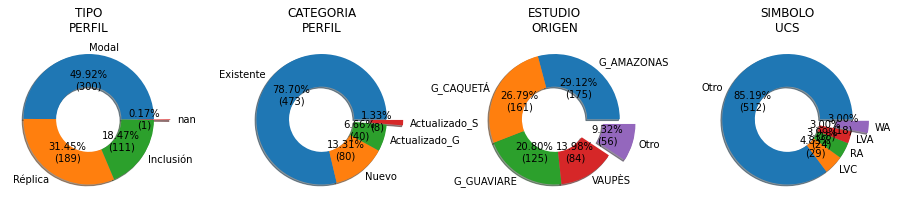

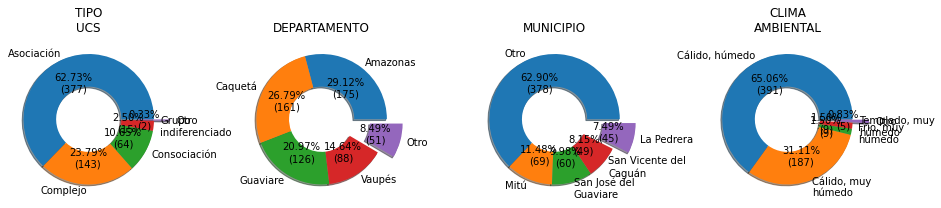

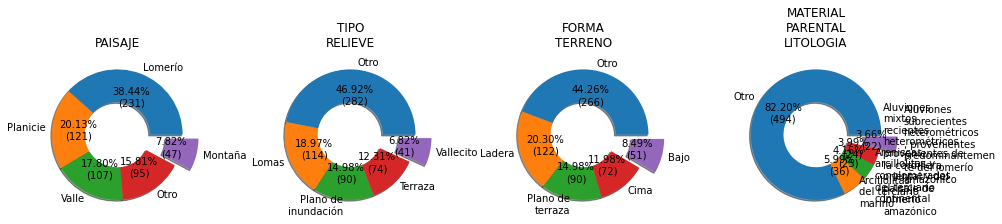

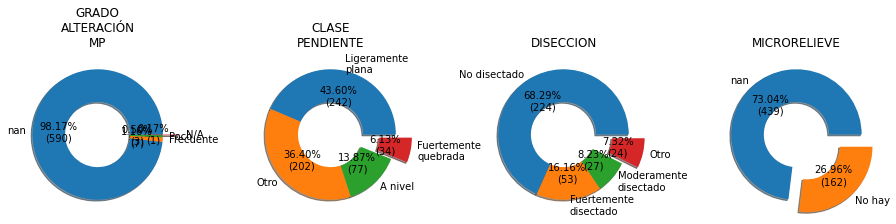

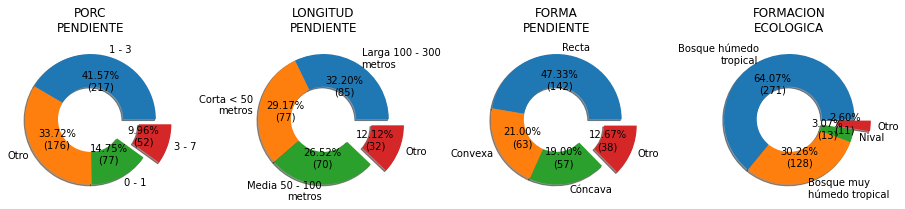

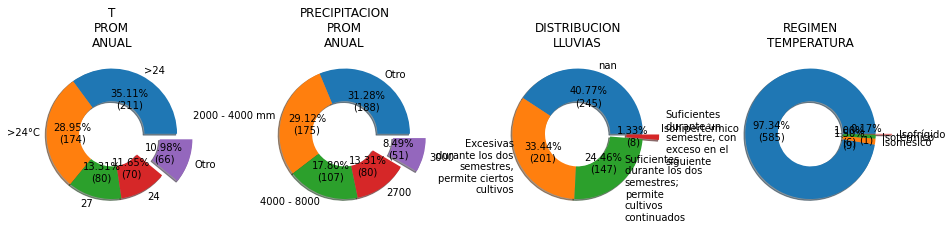

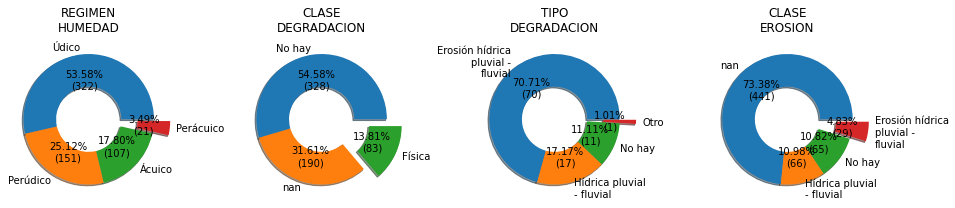

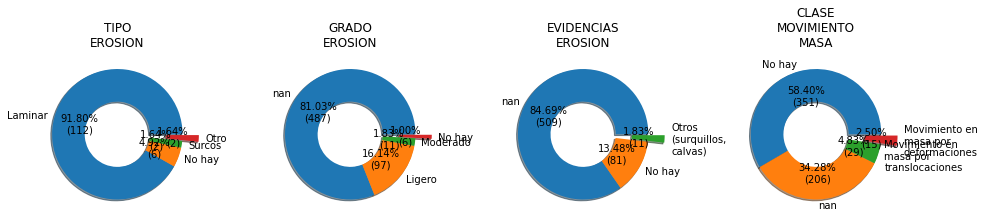

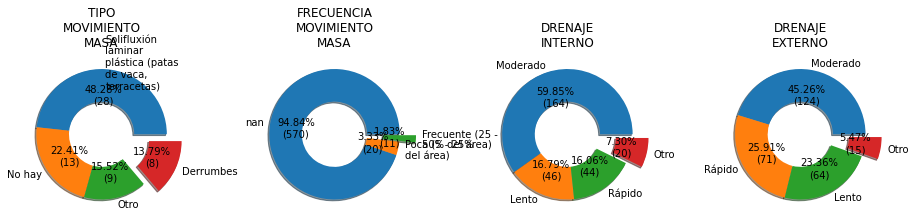

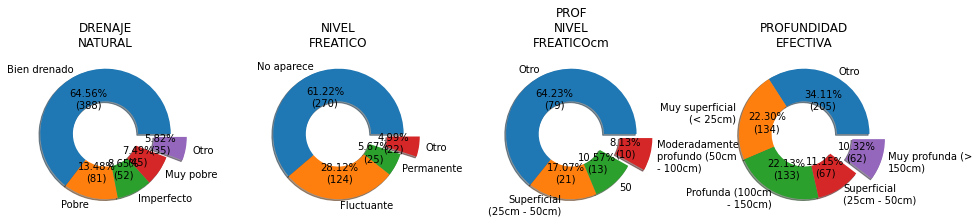

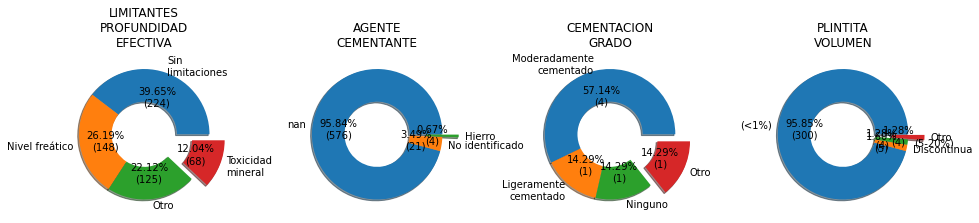

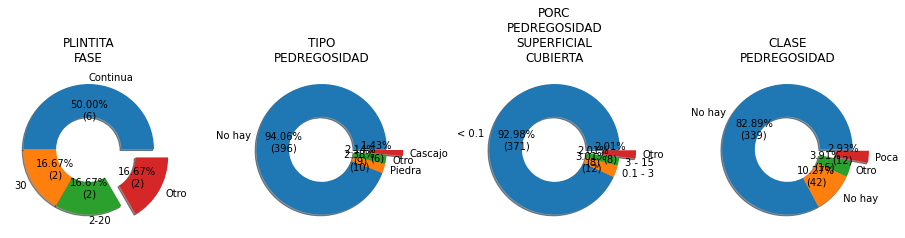

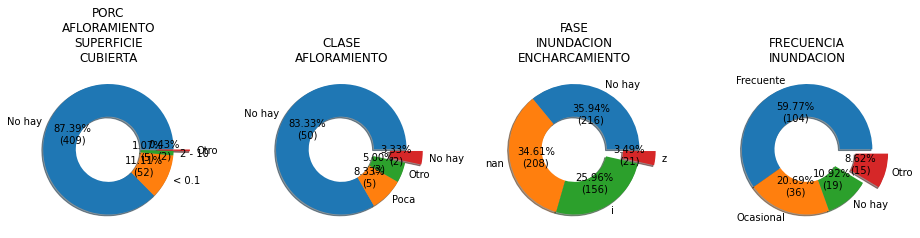

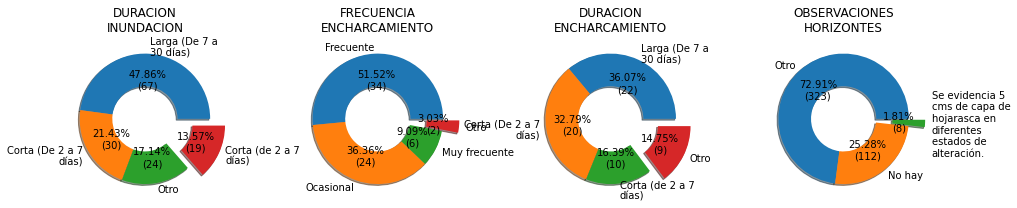

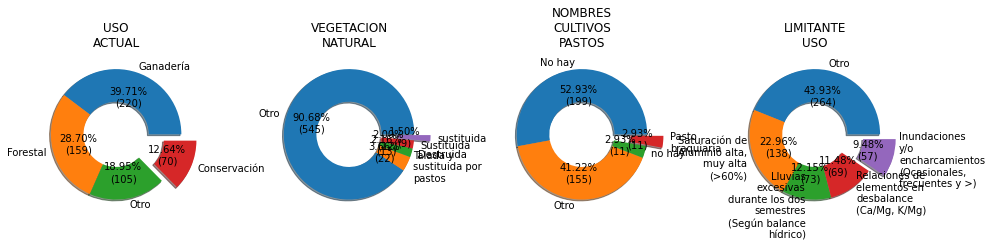

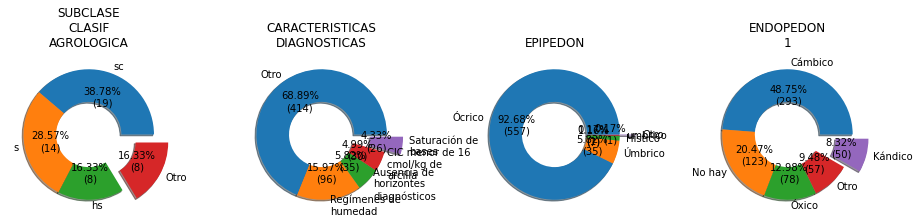

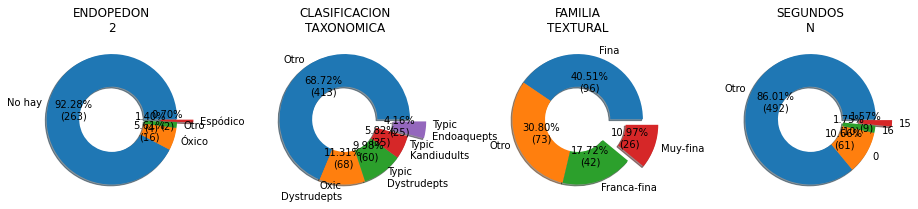

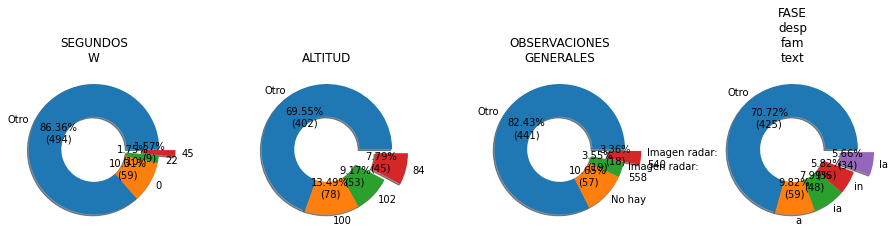

In [11]:
for i, row in enumerate(column_matrix):
    fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 3))
    
    axes = axes.ravel()
    
    for col, ax in zip(row, axes):
        df = encode_to_others(bdp_general[col]).value_counts()

        df.plot.pie(
            autopct=lambda p: '{:.2f}%\n({:,.0f})'.format(p, p * sum(df) / 100),
            explode=[0] * (len(df) - 1) + [0.25],
            shadow=True,
            ax=ax,
            wedgeprops=dict(width=0.5)
        )
        
        ax.set_ylabel('')
        ax.set_title("\n".join(col.split('_')))

    plt.show()
    fig.tight_layout()
    
    if i == 4:
        fig.savefig(f'{RENDER_PATH}/descriptive_variables.png')
#     break

In [12]:
half_threshold = bdp_general.shape[0] // 2

In [13]:
def plot_relevant_fields(fields: pd.Series, figsize=(16, 4), plot_threshold: bool = False):
    fig, ax = plt.subplots(figsize=figsize)

    fields.sort_values().astype(float).plot.bar(
        width=1,
        edgecolor='w'
    )

    ax.set_yscale('log')
    ax.grid(axis='y')

    if plot_threshold:
        ax.axhline(half_threshold, color='r')
        ax.text(len(fields) // 2, half_threshold + 5, f"Half threshold value: {half_threshold}")

    ax.set_ylabel(" ".join(fields.name.split('_')).capitalize())
    
    return fig, ax

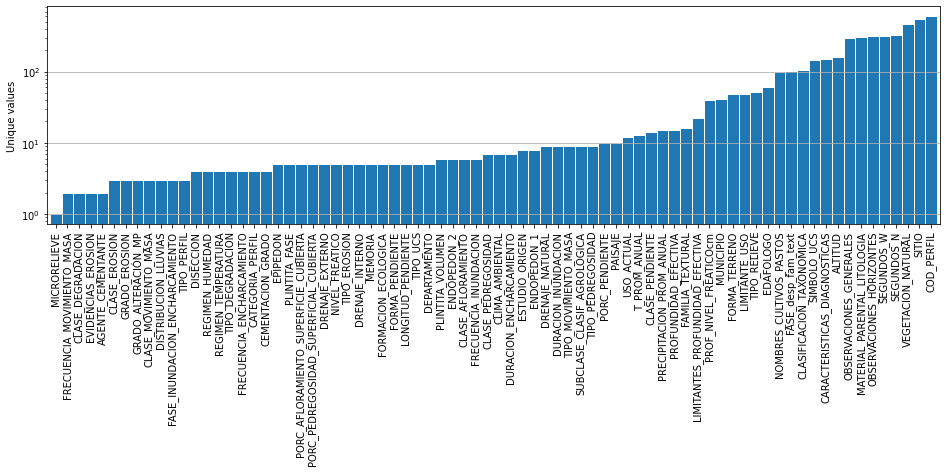

In [14]:
fig, ax = plot_relevant_fields(
    resumed_fields.T.query(
        "field_type == 'object'"
    )['unique_values'],
    plot_threshold=False
)

fig.savefig(f'{RENDER_PATH}/categorical_unique.png', dpi=300)

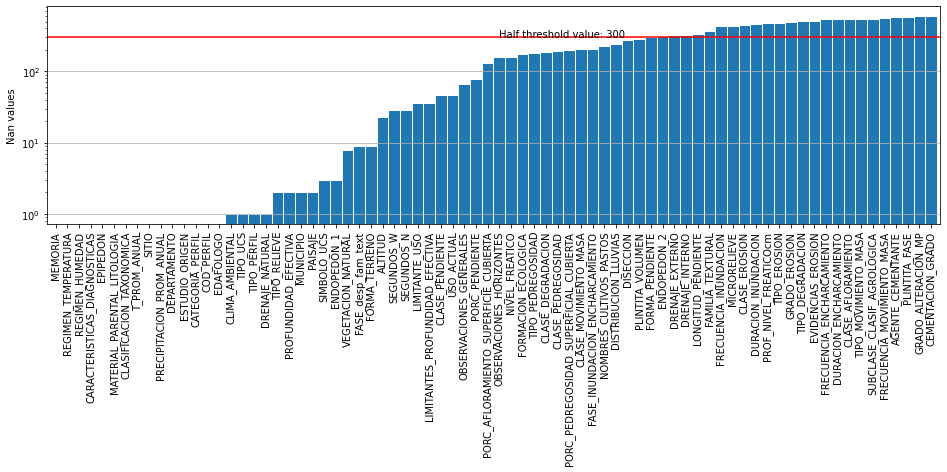

In [15]:
fig, ax = plot_relevant_fields(
    resumed_fields.T.query(
        "field_type == 'object'"
    )['nan_values'],
    plot_threshold=True
)

fig.savefig(f'{RENDER_PATH}/categorical_nan.png', dpi=300)

# Numerical variables

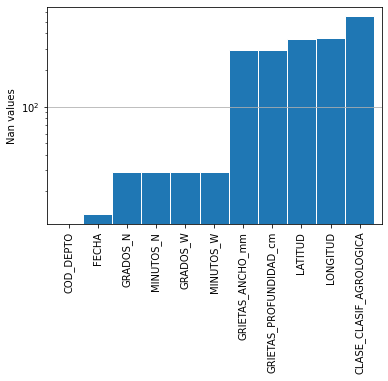

In [16]:
fig, ax = plot_relevant_fields(
    resumed_fields.T.query(
        "field_type != 'object'"
    )['nan_values'],
    figsize=(6, 4)
)

fig.savefig(f'{RENDER_PATH}/pure_numerical_nan.png')

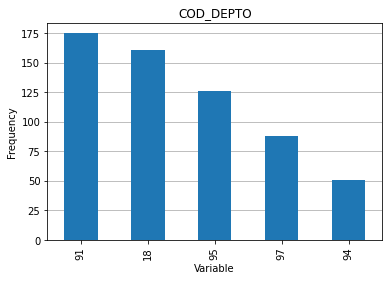

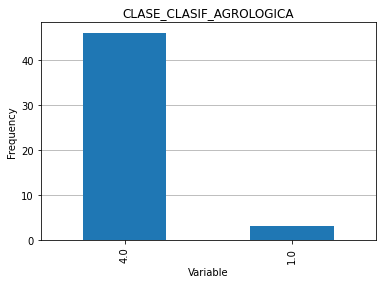

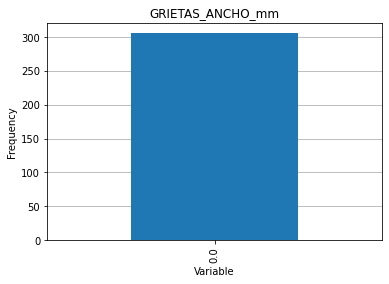

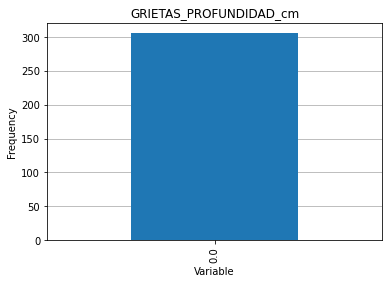

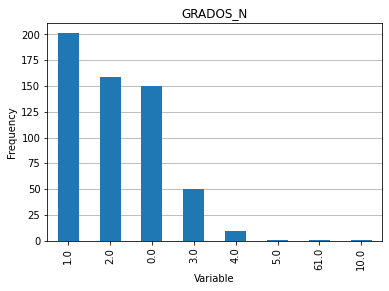

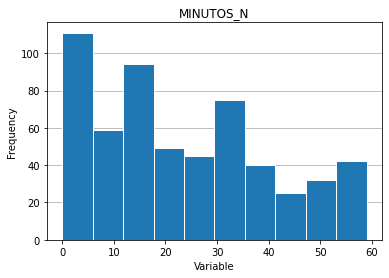

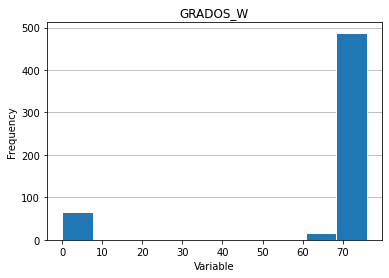

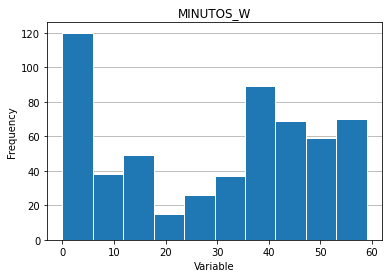

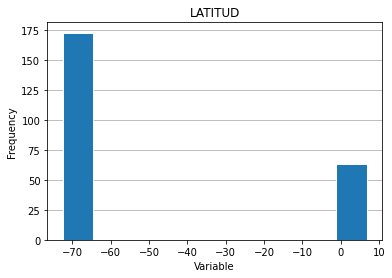

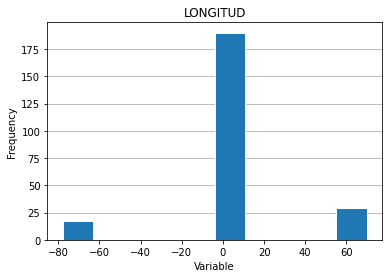

In [17]:
for row, item in resumed_fields.drop(columns='FECHA').T.query(
    "field_type != 'object'"
)['unique_values'].iteritems():
    fig, ax = plt.subplots()
    
    if item > 10:
        bdp_general[row].plot.hist(
            ax=ax,
            zorder=2,
            edgecolor='w'
        )
    else:
        bdp_general[row].value_counts().plot.bar(
            ax=ax,
            zorder=2
        )
        
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Variable')
    ax.set_title(row)
    
    ax.grid(axis='y', zorder=0)

# Map entries

In [18]:
departamentos = gpd.read_file('Polygons/depto.shp').astype({'DPTO': int})
departamentos.head()

,DPTO,NOMBRE_DPT,AREA,PERIMETER,HECTARES,geometry
0,5,ANTIOQUIA,6.335186e+10,1963728.843,6335185.555,"POLYGON ((754872.146 1445316.567, 755882.980 1..."
1,8,ATLANTICO,3.360765e+09,240936.172,336076.535,"POLYGON ((913511.163 1637374.172, 912870.293 1..."
2,11,SANTAFE DE BOGOTA D.C,1.650948e+09,323322.540,165094.778,"POLYGON ((1006435.805 1021680.392, 1006048.264..."
3,13,BOLIVAR,2.614189e+10,1309427.968,2614189.453,"POLYGON ((881889.901 1644370.282, 882454.535 1..."
4,15,BOYACA,2.335258e+10,1364539.911,2335258.246,"POLYGON ((1206427.930 1268967.315, 1207191.680..."


In [19]:
merged_geometries = departamentos.merge(
    bdp_general['COD_DEPTO'].value_counts().to_frame(name='Entries'),
    left_on='DPTO',
    right_index=True,
    how='left'
).fillna({'Entries': 0})

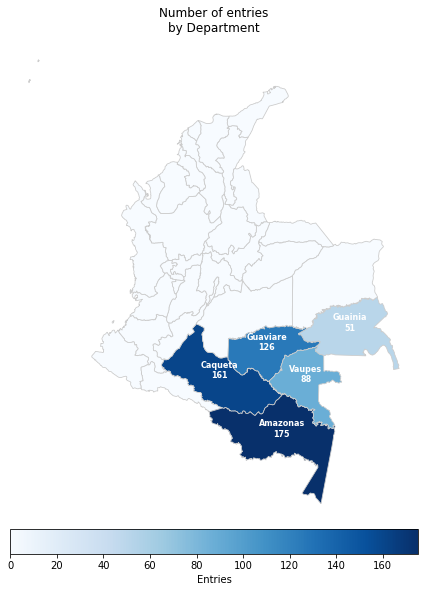

In [20]:
fig, ax = plt.subplots(
    figsize=(6, 10)
)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.05)

merged_geometries.plot(
    column='Entries',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8'
)

merged_geometries.apply(
    lambda x: ax.annotate(
        text=f"{x['NOMBRE_DPT'].title()}\n{x['Entries']:.0f}",
        xy=x['geometry'].centroid.coords[0],
        ha='center',
        fontsize=8,
        color='white',
        weight='bold',
    ) if x['Entries'] > 0 else None,
    axis=1
)

sm = plt.cm.ScalarMappable(
    cmap='Blues',
    norm=plt.Normalize(
        vmin=merged_geometries['Entries'].min(),
        vmax=merged_geometries['Entries'].max()
    )
)

sm._A = []

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")

cbar.set_label('Entries')

ax.set_title('Number of entries\nby Department')

ax.axis("off")

fig.tight_layout()

fig.savefig(f'{RENDER_PATH}/entries_by_deparment.png')